# Chest X-Ray Analysis

Student Name: Michael Tsypin

Instructor Name: Morgan Jones

Date: 5/23/2024

---

## Overview

The main goal of this project is to create a model that can predict whether a patient has pneumonia or not based on a chest x-ray image. Using various image classification with deep learning techniques, we will analyze chest x-ray images of pediatric patients from the Guangzhou Women and Children's Medical Center. Using this dataset, we will iterate through multiple models to determine which is the most accurate.

## Business Problem

A hospital wants to reduce the amount of time spent reviewing chest x-ray images. We need to create a model that is able to read and analyze chest x-ray images to determine if a patient has pneumonia. Using the dataset from the Guangzhou Women and Children's Medical Center, this model will be effective in producing mass results and accurate readings.

## Data Understanding

The data used in this project comes from the Guangzhou Women and Children's Medical Center (Kermany et al.). The chest x-ray images comes from pediatric patients between the ages of one to five years old who underwent chest x-ray imaging as part of their routine clinical workup. The images provided are anterior-posterior views of the chest. A total of three expert physicians graded these images to confirm the diagnoses of pneumonia or not to be cleared to use for model training.  

### Importing

In [1]:
#Import libraries
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

### Data Preparation

In [2]:
#Get train data from chest_xray dataset
train_folder = os.path.join('chest_x_ray', 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

#Get test data from chest_xray dataset
test_folder = os.path.join('chest_x_ray', 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

#Get validation data from chest_xray dataset
val_folder = os.path.join('chest_x_ray', 'val')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [3]:
#Look at train_pneumonia
train_pneumonia

'chest_x_ray/train/PNEUMONIA'

In [4]:
#Print number of pneumonia images in training set
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')

There are 3875 pneumonia images in the training set


In [5]:
#Print number of normal images in training set
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')

There are 1341 normal images in the training set


In [6]:
#Print number of pneumonia images in validation set
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 8 pneumonia images in the validation set


In [7]:
#Print number of normal images in validation set
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')

There are 8 normal images in the validation set


In [8]:
#Print number of pneumonia images in test set
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')

There are 390 pneumonia images in the test set


In [9]:
#Print number of normal images in test set
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')

There are 234 normal images in the test set


We have a total of 5856 images across the train, test, and validation sets that are categorized as either normal or pneumonia.

In [10]:
# get all the data in the directory chest_xray/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), batch_size = 624) 

# get all the data in the directory chest_xray/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(128, 128), batch_size = 16) 

# get all the data in the directory chest_xray/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(128, 128), batch_size = 5216) 

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [11]:
#Run train, test, and validation sets through generators
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

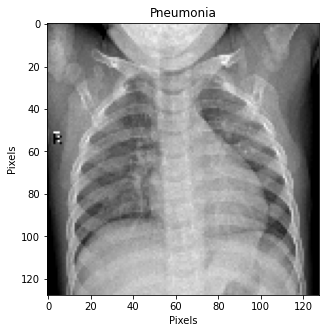

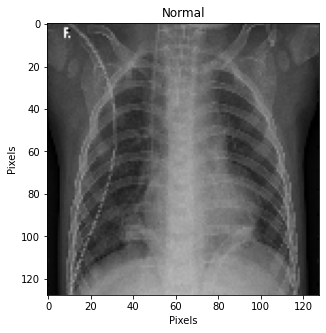

In [12]:
#Show image of pneumonia
plt.figure(figsize = (5,5))
plt.imshow(train_images[0], cmap='gray')
plt.title("Pneumonia")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

#Show image of normal lungs
plt.figure(figsize = (5,5))
plt.imshow(train_images[-1], cmap='gray')
plt.title("Normal")
plt.xlabel("Pixels")
plt.ylabel("Pixels");

The top image shows an example of a chest x-ray of a patient with pneumonia from the training set. The bottom image shows an example of a normal chest x-ray from the training set.

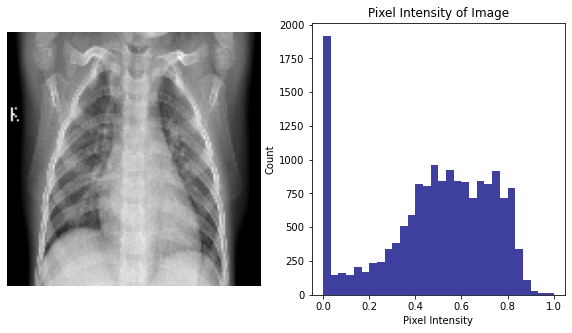

In [13]:
#Create histogram of pixel intensity
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(train_images[1])
plt.axis('off')
histogram = plt.subplot(1,2,2)
histogram.set_title("Pixel Intensity of Image")
histogram.set_ylabel('Count')
histogram.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(train_images[1][:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(train_images[1][:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(train_images[1][:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

The image on the right depicts a histogram of the pixel intensity of the chest x-ray shown on the left.

In [14]:
# Explore dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [15]:
#Reshape data sets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


In [16]:
#Reshape data sets
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

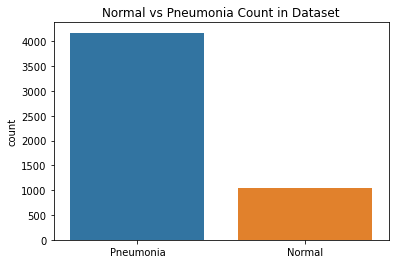

In [17]:
#Get count of pneumonia vs normal within dataset
count = []

for i in train_img:
    if(i[1] == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia")
sns.countplot(count).set(title="Normal vs Pneumonia Count in Dataset");

The plot shown above depicts the count of the number of normal chest x-rays within the training dataset versus the number of chest x-ray images with pneumonia in the training dataset. Here we see that there is about three times the amount of pneumonia images compared to the number of normal images. This imbalance in the data can potentially lead to less accurate results as there are not enough normal images to train the models compared to the number of pneumonia images.

### Modeling

#### Baseline

We will now proceed with our baseline model. We will use this model to compare future models in order to determine how successful our future models are.

In [18]:
#Create baseline model
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
#Compile the baseline model
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
#Print summary of baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                983060    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 983,253
Trainable params: 983,253
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Train the baseline model
history = baseline_model.fit(train_img,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/70
163/163 [==============================] - 1s 5ms/step - loss: 0.5701 - accuracy: 0.7293 - val_loss: 0.7990 - val_accuracy: 0.5000
Epoch 2/70
163/163 [==============================] - 1s 4ms/step - loss: 0.4028 - accuracy: 0.8000 - val_loss: 0.7485 - val_accuracy: 0.6875
Epoch 3/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2907 - accuracy: 0.8863 - val_loss: 0.8270 - val_accuracy: 0.6875
Epoch 4/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2476 - accuracy: 0.9041 - val_loss: 0.5010 - val_accuracy: 0.8125
Epoch 5/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1891 - accuracy: 0.9227 - val_loss: 0.3314 - val_accuracy: 0.8750
Epoch 6/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1870 - accuracy: 0.9277 - val_loss: 0.2722 - val_accuracy: 0.9375
Epoch 7/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1727 - accuracy: 0.9279 - val_loss: 0.2635 - val_accuracy: 0.9375
Epoch 

In [22]:
#Get training loss and accuracy results
results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 2ms/step - loss: 0.1082 - accuracy: 0.9551


In [23]:
#Get test loss and accuracy results
results_test = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 5ms/step - loss: 1.5218 - accuracy: 0.6939


In [24]:
#View train results
results_train

[0.1082104966044426, 0.9551380276679993]

In [25]:
#View test results
results_test

[1.521794080734253, 0.6939102411270142]

We will be using accuracy as the metric to determine how well our models perform. The results of our baseline model show that the train set had an accuracy score of 0.9551 and a test set score of 0.6939. We will use the testing accuarcy as a baseline when comparing differnet models to determine success of that model. 

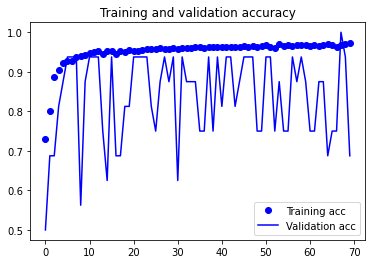

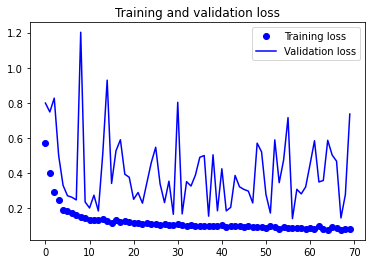

In [26]:
#Plot accuracy vs number of epochs and loss vs number of epochs for baseline model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our baseline model results.

#### Normalization

We will now try tuning our neural network using normalization.

In [27]:
#Create model 2
model_2 = models.Sequential()
model_2.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [28]:
#Compile model 2
model_2.compile(optimizer='sgd',
             loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
#Print summary of model 2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                983060    
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 983,361
Trainable params: 983,307
Non-trainable params: 54
_______________________________________________

In [30]:
#Train model 2
history_2 = model_2.fit(train_img,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/70
163/163 [==============================] - 1s 5ms/step - loss: 0.3860 - accuracy: 0.8867 - val_loss: 0.7761 - val_accuracy: 0.6250
Epoch 2/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2298 - accuracy: 0.9457 - val_loss: 0.9514 - val_accuracy: 0.6250
Epoch 3/70
163/163 [==============================] - 1s 5ms/step - loss: 0.1597 - accuracy: 0.9532 - val_loss: 0.5786 - val_accuracy: 0.8125
Epoch 4/70
163/163 [==============================] - 1s 5ms/step - loss: 0.1290 - accuracy: 0.9599 - val_loss: 1.2717 - val_accuracy: 0.5625
Epoch 5/70
163/163 [==============================] - 1s 5ms/step - loss: 0.1029 - accuracy: 0.9672 - val_loss: 0.5008 - val_accuracy: 0.7500
Epoch 6/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1001 - accuracy: 0.9672 - val_loss: 0.3315 - val_accuracy: 0.8125
Epoch 7/70
163/163 [==============================] - 1s 4ms/step - loss: 0.0932 - accuracy: 0.9709 - val_loss: 0.5795 - val_accuracy: 0.7500
Epoch 

In [31]:
#Get training loss and accuracy of model 2
results_train_2 = model_2.evaluate(train_img, train_y)

163/163 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9954


In [32]:
#Get test loss and accuracy of model 2
results_test_2 = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 0s 3ms/step - loss: 1.6836 - accuracy: 0.7179


In [33]:
#View train results
results_train_2

[0.015005514025688171, 0.995398759841919]

In [34]:
#View test results
results_test_2

[1.6836432218551636, 0.7179487347602844]

Our normalization model has a test accuracy score of 0.7179, which is a slight improvement compared to our baseline model. While normalization did improve the accuracy score, we will attempt to increase the accuracy score even further by performing a Convolutional Neural Network (CNN).

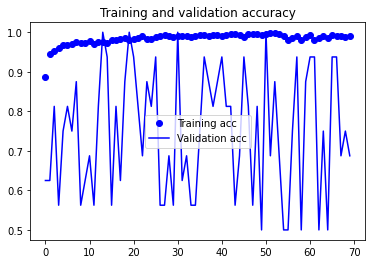

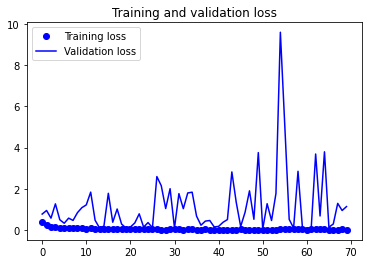

In [35]:
#Plot accuracy vs number of epochs and loss vs number of epochs for normalization model
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our normalization model results.

#### CNN

We will now try a Convolutional Neural Network (CNN) to see if we can find a better accuracy score. 

In [36]:
#Create model 3
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [37]:
#Compile model 3
model_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [38]:
#Print summary of model 3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

In [39]:
#Train model 3
history_3 = model_3.fit(train_images,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/70
163/163 [==============================] - 40s 248ms/step - loss: 0.5312 - accuracy: 0.7523 - val_loss: 0.8661 - val_accuracy: 0.5000
Epoch 2/70
163/163 [==============================] - 41s 250ms/step - loss: 0.4067 - accuracy: 0.8244 - val_loss: 0.7089 - val_accuracy: 0.6250
Epoch 3/70
163/163 [==============================] - 40s 246ms/step - loss: 0.2816 - accuracy: 0.8836 - val_loss: 0.6095 - val_accuracy: 0.7500
Epoch 4/70
163/163 [==============================] - 40s 247ms/step - loss: 0.2045 - accuracy: 0.9220 - val_loss: 0.7057 - val_accuracy: 0.6250
Epoch 5/70
163/163 [==============================] - 41s 253ms/step - loss: 0.1671 - accuracy: 0.9363 - val_loss: 0.6067 - val_accuracy: 0.6875
Epoch 6/70
163/163 [==============================] - 41s 249ms/step - loss: 0.1428 - accuracy: 0.9469 - val_loss: 0.3187 - val_accuracy: 0.8750
Epoch 7/70
163/163 [==============================] - 40s 247ms/step - loss: 0.1239 - accuracy: 0.9540 - val_loss: 0.3606 - val_ac

In [40]:
#Get training loss and accuracy of model 3
results_train_3 = model_3.evaluate(train_images, train_y)

163/163 [==============================] - 9s 57ms/step - loss: 0.0039 - accuracy: 0.9996


In [41]:
#Get test loss and accuracy of model 3
results_test_3 = model_3.evaluate(test_images, test_y)

20/20 [==============================] - 1s 61ms/step - loss: 1.9523 - accuracy: 0.7644


In [42]:
#View train results
results_train_3

[0.0039240894839167595, 0.9996165633201599]

In [43]:
#View test results
results_test_3

[1.9523067474365234, 0.7644230723381042]

Our CNN model has a test accuracy score of 0.7644 which is the best performing model so far. We can attempt to increase the score even further by adding normalization to our CNN.

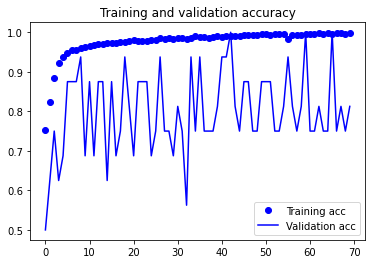

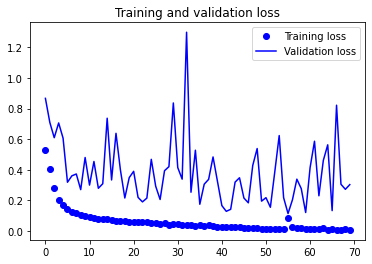

In [44]:
#Plot accuracy vs number of epochs and loss vs number of epochs for CNN model
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our CNN model results.

We wil now try to normalize the previous CNN model.

In [45]:
#Create model 4
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model_4.add(BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [46]:
#Compile model 4
model_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [47]:
#Print summary of model 4
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)       

In [48]:
#Train model 4
history_4 = model_4.fit(train_images,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/70
163/163 [==============================] - 64s 392ms/step - loss: 0.1921 - accuracy: 0.9350 - val_loss: 2.6193 - val_accuracy: 0.5000
Epoch 2/70
163/163 [==============================] - 60s 368ms/step - loss: 0.0623 - accuracy: 0.9760 - val_loss: 3.6869 - val_accuracy: 0.5000
Epoch 3/70
163/163 [==============================] - 58s 357ms/step - loss: 0.0404 - accuracy: 0.9847 - val_loss: 3.3211 - val_accuracy: 0.5000
Epoch 4/70
163/163 [==============================] - 62s 379ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.3764 - val_accuracy: 0.8750
Epoch 5/70
163/163 [==============================] - 62s 381ms/step - loss: 0.0175 - accuracy: 0.9937 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 6/70
163/163 [==============================] - 63s 389ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 7/70
163/163 [==============================] - 62s 381ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0705 - val_ac

In [49]:
#Get training loss and accuracy of model 4
results_train_4 = model_4.evaluate(train_images, train_y)

163/163 [==============================] - 13s 78ms/step - loss: 9.6613e-05 - accuracy: 1.0000


In [50]:
#Get test loss and accuracy of model 4
results_test_4 = model_4.evaluate(test_images, test_y)

20/20 [==============================] - 2s 77ms/step - loss: 2.3166 - accuracy: 0.7356


In [51]:
#View train results
results_train_4

[9.661262447480112e-05, 1.0]

In [52]:
#View test results
results_test_4

[2.31662917137146, 0.7355769276618958]

Our normalized CNN model has a test accuracy score of 0.7356. This is better than our baseline model, but not as accurate as the original CNN model.

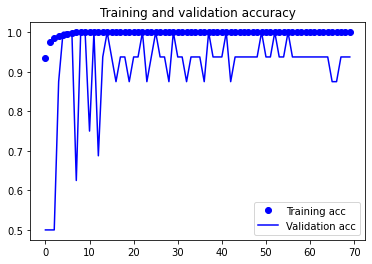

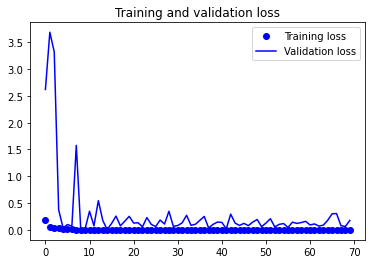

In [53]:
#Plot accuracy vs number of epochs and loss vs number of epochs for CNN/Normalization model
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The original CNN model had the best test accuracy score of all the models (0.7644), therefore this will be our final model that we recommend.

In [54]:
#Create predictions
predictions = model_3.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [55]:
#Print classification report
print(classification_report(test_y, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.73      0.99      0.84       390
   Normal (Class 1)       0.98      0.38      0.55       234

           accuracy                           0.76       624
          macro avg       0.85      0.69      0.69       624
       weighted avg       0.82      0.76      0.73       624



In [56]:
#Print confusion matrix
cm = confusion_matrix(test_y,predictions)
cm

array([[388,   2],
       [145,  89]])

In [57]:
#Convery confusion matrix to dataframe
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

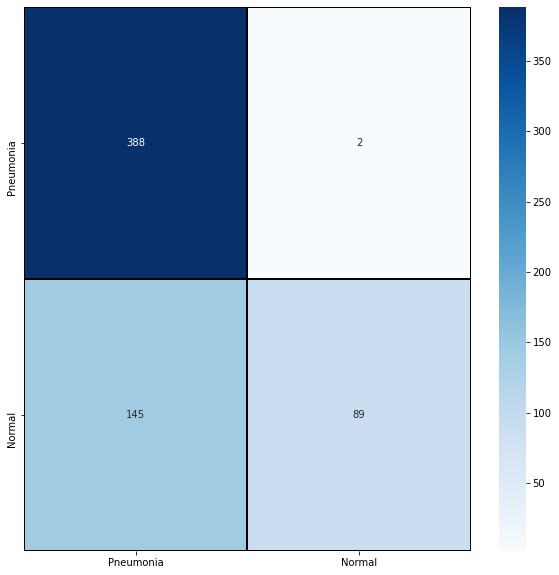

In [58]:
#Graph confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ["Pneumonia", "Normal"],yticklabels = ["Pneumonia", "Normal"]);

False positives are the most detrimental to our model. A false positive in this instance is where our model categorizes a chest x-ray image has having pneumonia when in reality the lungs are normal and healthy. This is an issue with misdiagnosis of a patient. Our confusion matrix shows us that there are 145 false positives.

In [59]:
#Create explanation for lime
x=10
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
                 val_images[x], 
                model_3.predict,top_labels=2)
        

image, mask = explanation.get_image_and_mask(0,
                             hide_rest=False)

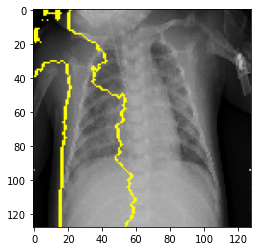

In [60]:
#Use lime on pneumonia image
plt.imshow(mark_boundaries(image, mask));

We can use LIME to help us interpret the model's results. LIME (Local Interpretable Model-agnostic Explanations) is used as an explanation of the model in how it reads and digests the image to make its decision. In the image above, we can see that the model is looking at the part of the image within the yellow outline to show us where the model sees pneumonia within the lungs and therefore classifies the image as having pneumonia. LIME is also helpful to us as it can be used help a radiologist make a diagnosis faster by viewing the outlined part of the chest x-ray and help make a diagnosis.

## Conclusion

The best and final model we found based on accuracy score was our Convolutional Neural Network (CNN) model. This model has an accuracy score of about 76.5%. We would recommend that the hospital use this model to feed chest x-rays so that a radiologist can use the model's prediction to help determine a diagnosis of pneumonia or not. We would also recommend that the radiologist use LIME to aid diagnosis assistance by making more accurate and quicker diagnoses using LIME outlines. 